In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from pprint import pprint
from time import time, strftime, gmtime
import focal_tversky as ft
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

C:\Users\sibog\AppData\Local\pypoetry\Cache\virtualenvs\dash-auyr-m8jWGRqX-py3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from deeplabv3plus import deeplabv3_3d as dp
import importlib
importlib.reload(ft)

<module 'focal_tversky' from 'C:\\Apps\\Ayur\\dash_auyr\\notebooks\\focal_tversky.py'>

In [3]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [5]:
from typing import Optional
from linecache import getline
import numpy as np
import torch
from torch.utils.data import Dataset


class SegyDataset(Dataset):
    """Dataset with 3D slice of seg-y file"""

    def __init__(
        self,
        segy_filepath: str,
        fault_filepath: str,
        fault_coords_filepath: str,
        cube_size: int = 64,
    ):
        """
        Create dataset for seg-y file
        Args:
            segy_filepath: path to seismic data (.npz format)
            fault_filepath: path to file with mask (.npz format)
            fault_coords_filepath: path to file with mask coords (.txt format),
            cube_size: cube_size of cube
        """
        self.cube_size = cube_size
        self.segy_filepath = segy_filepath
        self.fault_filepath = fault_filepath
        self.fault_coords_filepath = fault_coords_filepath
        self.length = self._get_dataset_length()

    def _get_dataset_length(self):
        with open(self.fault_coords_filepath) as fault_file:
            length = 0
            for _ in fault_file:
                length += 1
        return length

    def __len__(self):
        return self.length

    def _get_coords(self, index) -> list[int, int, int]:
        line = getline(self.fault_coords_filepath, index + 1)
        result = []
        for item in line.split(' '):
            if item.isdigit():
                result.append(int(item))
        return result

    def __getitem__(self, idx):
        with np.load(self.fault_filepath, mmap_mode='r') as fault_data, \
            np.load(self.segy_filepath, mmap_mode='r') as segy_data:
            iline, xline, zline = self._get_coords(idx)
            fault_slice = fault_data['arr_0'][
                iline: iline + self.cube_size,
                xline: xline + self.cube_size,
                zline: zline + self.cube_size,
            ]
            segy_slice = segy_data['arr_0'][
                iline: iline + self.cube_size,
                xline: xline + self.cube_size,
                zline: zline + self.cube_size,
            ]
            X = torch.from_numpy(segy_slice)
            Y = torch.from_numpy(fault_slice)
            return X[None, :], Y[None, :]


In [6]:
from typing import Optional
from linecache import getline
import numpy as np
import torch
from torch.utils.data import Dataset


class SegyDataset(Dataset):
    """Dataset with 3D slice of seg-y file"""

    def __init__(
        self,
        data_filepath: str,
        dataset_type: str,
        cube_size: int = 64,
    ):
        """
        Create dataset for seg-y file
        Args:
            segy_filepath: path to seismic data (.npz format)
            fault_filepath: path to file with mask (.npz format)
            fault_coords_filepath: path to file with mask coords (.txt format),
            cube_size: cube_size of cube
        """
        self.cube_size = cube_size
        self.data_filepath = data_filepath
        self.dataset_type = dataset_type
        self.length = self._get_dataset_length()
        print(self.length)

    def _get_dataset_length(self):
        return len(os.listdir(self.data_filepath + '\\'+ self.dataset_type + '\\seis\\'))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with np.load(self.data_filepath + f'\\{self.dataset_type}\\fault\\fault_{idx}.npz', mmap_mode='r') as fault_data, \
            np.load(self.data_filepath + f'\\{self.dataset_type}\\seis\\seis_{idx}.npz', mmap_mode='r') as segy_data:
            X = torch.from_numpy(segy_data['arr_0'])
            Y = torch.from_numpy(fault_data['arr_0'])
            X_max = X.max()
            X_min = X.min()
            X = (X - X_min) / (X_max - X_min)
            return X[None, :], Y[None, :]


In [8]:
from torch import nn

class UNet3D_256(torch.nn.Module):
    def __init__(self):
        super(UNet3D_256, self).__init__()

        self.layer_encoder_1 = self.__get_encoder_layer(
            1, 32, kernel_size=3, stride=1, padding=1
            )
        self.layer_encoder_2 = self.__get_encoder_layer(
            32, 64, kernel_size=3, stride=1, padding=1
            )

        self.layer_encoder_3 = self.__get_encoder_layer(
            64, 64, kernel_size=3, stride=1, padding=1
            )
        self.layer_encoder_4 = self.__get_encoder_layer(
            64, 128, kernel_size=3, stride=1, padding=1
            )

        self.layer_encoder_5 = self.__get_encoder_layer(
            128, 128, kernel_size=3, stride=1, padding=1
            )
        self.layer_encoder_6 = self.__get_encoder_layer(
            128, 256, kernel_size=3, stride=1, padding=1
            )

        self.layer_encoder_7 = self.__get_encoder_layer(
            256, 256, kernel_size=3, stride=1, padding=1
            )
        self.layer_encoder_8 = self.__get_encoder_layer(
            256, 512, kernel_size=3, stride=1, padding=1
            )

        self.max_pool_1 = nn.MaxPool3d(2)
        self.max_pool_2 = nn.MaxPool3d(2)
        self.max_pool_3 = nn.MaxPool3d(2)

        self.layer_decoder_1 = self.__get_decoder_layer(
            512, 512, kernel_size=2, stride=2
            )
        self.layer_decoder_2 = self.__get_encoder_layer(
            256 + 512, 256, kernel_size=3, stride=1, padding=1
            )
        self.layer_decoder_3 = self.__get_encoder_layer(
            256, 256, kernel_size=3, stride=1, padding=1
            )

        self.layer_decoder_4 = self.__get_decoder_layer(
            256, 256, kernel_size=2, stride=2
            )
        self.layer_decoder_5 = self.__get_encoder_layer(
            128 + 256, 128, kernel_size=3, stride=1, padding=1
            )
        self.layer_decoder_6 = self.__get_encoder_layer(
            128, 128, kernel_size=3, stride=1, padding=1
            )

        self.layer_decoder_7 = self.__get_decoder_layer(
            128, 128, kernel_size=2, stride=2
            )
        self.layer_decoder_8 = self.__get_encoder_layer(
            64 + 128, 64, kernel_size=3, stride=1, padding=1
            )
        self.layer_decoder_9 = self.__get_encoder_layer(
            64, 1, kernel_size=3, stride=1, padding=1
            )
        self.layer_10 = nn.Sequential(nn.Conv3d(1, 1, kernel_size=1, stride=1))

    def forward(self, x):
        # ----------encoder start----------
        x = x.to(torch.float32)
        first_layer_encoder = self.layer_encoder_2(self.layer_encoder_1(x))
        x = self.max_pool_1(first_layer_encoder)

        second_layer_encoder = self.layer_encoder_4(self.layer_encoder_3(x))
        x = self.max_pool_2(second_layer_encoder)
        third_layer_encoder = self.layer_encoder_6(self.layer_encoder_5(x))

        x = self.max_pool_3(third_layer_encoder)
        x = self.layer_encoder_8(self.layer_encoder_7(x))
        # ----------encoder end----------

        # ----------decoder start----------
        x = self.layer_decoder_1(x)
        third_layer_decoder = torch.cat((x, third_layer_encoder), 1)
        del third_layer_encoder
        x = self.layer_decoder_3(self.layer_decoder_2(third_layer_decoder))
        del third_layer_decoder

        x = self.layer_decoder_4(x)
        second_layer_decoder = torch.cat((x, second_layer_encoder), 1)
        del second_layer_encoder
        x = self.layer_decoder_6(self.layer_decoder_5(second_layer_decoder))
        del second_layer_decoder

        x = self.layer_decoder_7(x)
        first_layer_decoder = torch.cat((x, first_layer_encoder), 1)
        del first_layer_encoder
        x = self.layer_decoder_9(self.layer_decoder_8(first_layer_decoder))
        del first_layer_decoder
        # ----------edcoder end----------
        x = self.layer_10(x)
        x = self.sigmoid(x)
        return x

    def __get_encoder_layer(
        self, input_channel=1, output_channel=64, kernel_size=3, stride=1,
        padding=0, batch_norm=True, padding_mode='replicate'
        ):
        if batch_norm:
            return nn.Sequential(
                nn.Conv3d(
                    input_channel, output_channel,
                    kernel_size=kernel_size, stride=stride, padding=padding,
                    padding_mode=padding_mode
                    ),
                nn.BatchNorm3d(output_channel),
                nn.ReLU()
                )
        return nn.Sequential(
            nn.Conv3d(
                input_channel, output_channel, kernel_size=kernel_size,
                stride=stride, padding=padding
                ),
            nn.ReLU()
            )

    def __get_decoder_layer(
        self, input_channel=1, output_channel=64, kernel_size=3, stride=1,
        padding=0
        ):
        return nn.Sequential(
            nn.ConvTranspose3d(
                input_channel, output_channel, kernel_size=kernel_size,
                stride=stride, padding=padding
                )
            )

In [9]:
from torch import nn

class UNet3D_256(torch.nn.Module):
    def __init__(self):
        super(UNet3D_256, self).__init__()

        self.layer_encoder_1 = self.__get_encoder_layer(
            1, 16, kernel_size=3, stride=1, padding=1
            )
        self.layer_encoder_2 = self.__get_encoder_layer(
            16, 32, kernel_size=3, stride=1, padding=1
            )

        self.layer_encoder_3 = self.__get_encoder_layer(
            32, 32, kernel_size=3, stride=1, padding=1
            )
        self.layer_encoder_4 = self.__get_encoder_layer(
            32, 64, kernel_size=3, stride=1, padding=1
            )

        self.layer_encoder_5 = self.__get_encoder_layer(
            64, 64, kernel_size=3, stride=1, padding=1
            )
        self.layer_encoder_6 = self.__get_encoder_layer(
            64, 128, kernel_size=3, stride=1, padding=1
            )

        self.layer_encoder_7 = self.__get_encoder_layer(
            128, 128, kernel_size=3, stride=1, padding=1
            )
        self.layer_encoder_8 = self.__get_encoder_layer(
            128, 256, kernel_size=3, stride=1, padding=1
            )

        self.max_pool_1 = nn.MaxPool3d(2)
        self.max_pool_2 = nn.MaxPool3d(2)
        self.max_pool_3 = nn.MaxPool3d(2)

        self.layer_decoder_1 = self.__get_decoder_layer(
            256, 256, kernel_size=2, stride=2
            )
        self.layer_decoder_2 = self.__get_encoder_layer(
            128 + 256, 128, kernel_size=3, stride=1, padding=1
            )
        self.layer_decoder_3 = self.__get_encoder_layer(
            128, 128, kernel_size=3, stride=1, padding=1
            )

        self.layer_decoder_4 = self.__get_decoder_layer(
            128, 128, kernel_size=2, stride=2
            )
        self.layer_decoder_5 = self.__get_encoder_layer(
            64 + 128, 64, kernel_size=3, stride=1, padding=1
            )
        self.layer_decoder_6 = self.__get_encoder_layer(
            64, 64, kernel_size=3, stride=1, padding=1
            )

        self.layer_decoder_7 = self.__get_decoder_layer(
            64, 64, kernel_size=2, stride=2
            )
        self.layer_decoder_8 = self.__get_encoder_layer(
            32 + 64, 32, kernel_size=3, stride=1, padding=1
            )
        self.layer_decoder_9 = self.__get_encoder_layer(
            32, 1, kernel_size=3, stride=1, padding=1
            )
        self.layer_10 = nn.Sequential(nn.Conv3d(1, 1, kernel_size=1, stride=1))

    def forward(self, x):
        # ----------encoder start----------
        x = x.to(torch.float32)
        first_layer_encoder = self.layer_encoder_2(self.layer_encoder_1(x))
        x = self.max_pool_1(first_layer_encoder)

        second_layer_encoder = self.layer_encoder_4(self.layer_encoder_3(x))
        x = self.max_pool_2(second_layer_encoder)
        third_layer_encoder = self.layer_encoder_6(self.layer_encoder_5(x))

        x = self.max_pool_3(third_layer_encoder)
        x = self.layer_encoder_8(self.layer_encoder_7(x))
        # ----------encoder end----------

        # ----------decoder start----------
        x = self.layer_decoder_1(x)
        third_layer_decoder = torch.cat((x, third_layer_encoder), 1)
        del third_layer_encoder
        x = self.layer_decoder_3(self.layer_decoder_2(third_layer_decoder))
        del third_layer_decoder

        x = self.layer_decoder_4(x)
        second_layer_decoder = torch.cat((x, second_layer_encoder), 1)
        del second_layer_encoder
        x = self.layer_decoder_6(self.layer_decoder_5(second_layer_decoder))
        del second_layer_decoder

        x = self.layer_decoder_7(x)
        first_layer_decoder = torch.cat((x, first_layer_encoder), 1)
        del first_layer_encoder
        x = self.layer_decoder_9(self.layer_decoder_8(first_layer_decoder))
        del first_layer_decoder
        # ----------edcoder end----------
        x = self.layer_10(x)
        return x

    def __get_encoder_layer(
        self, input_channel=1, output_channel=64, kernel_size=3, stride=1,
        padding=0, batch_norm=True, padding_mode='zeros'
        ):
        if batch_norm:
            return nn.Sequential(
                nn.Conv3d(
                    input_channel, output_channel,
                    kernel_size=kernel_size, stride=stride, padding=padding,
                    padding_mode=padding_mode
                    ),
                nn.BatchNorm3d(output_channel),
                nn.ReLU()
                )
        return nn.Sequential(
            nn.Conv3d(
                input_channel, output_channel, kernel_size=kernel_size,
                stride=stride, padding=padding
                ),
            nn.ReLU()
            )

    def __get_decoder_layer(
        self, input_channel=1, output_channel=64, kernel_size=3, stride=1,
        padding=0
        ):
        return nn.Sequential(
            nn.ConvTranspose3d(
                input_channel, output_channel, kernel_size=kernel_size,
                stride=stride, padding=padding
                )
            )

In [10]:
from torch import optim

class LitModel(pl.LightningModule):
    def __init__(
        self,
        model,
        loss,
        lr_rate: float,
    ):
        super().__init__()
        self._lr_rate = lr_rate
        self.model = model
        self.loss = loss
        self.valid_loss = []
        self.train_loss = []

    def forward(self, x):
        y_pred = self.model(x)
        return y_pred

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self._lr_rate)
        return optimizer

    def get_metrics(self, y_pred, y, metrics_type="train"):
        values = smp.metrics.functional.get_stats(
            (y_pred > 0.5).type(torch.int32), y.type(torch.int32),
            mode='binary'
            )
        iou = smp.metrics.functional.iou_score(*values)
        # self.log(f'iou/{metrics_type}', torch.mean(iou), prog_bar=True)

    def training_step(self, batch, batch_idx):
        x, y = batch

        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        correct = y_pred.argmax(dim=1).eq(y).sum().item()
        self.train_loss.append(loss)
        self.get_metrics(y_pred, y, 'train')
        logs = {"train_loss": loss}
        self.log(f'loss/train', loss, prog_bar=True)
        # return loss
        return {
            'loss': loss,
            'log': logs,
            'correct': correct,
            'total': len(y)
        }

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch

        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        correct = y_pred.argmax(dim=1).eq(y).sum().item()
        self.valid_loss.append(loss)
        # self.get_metrics(y_pred, y, 'valid')
        logs = {"train_loss": loss}
        # #return loss
        return {
            'loss': loss,
            'log': logs,
            'correct': correct,
            'total': len(y)
        }

    def test_step(self, batch, batch_idx):
        x, y = batch

        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        self.get_metrics(y_pred, y, 'test')
        return loss

In [11]:
from unet_3d import UNet3D

In [12]:
seis_path = 'data/seistrain1.npz'
fault_mask_path = 'data/faulttrain1.npz'
coords_mask_path = 'data/masks_29_04_2023_14_08.txt'
batch_size=1

In [133]:
train_dataset = SegyDataset(
    data_filepath='data_128',
    dataset_type='train',
)
eval_dataset = SegyDataset(
    data_filepath='data_128',
    dataset_type='eval',
)
test_dataset = SegyDataset(
    data_filepath='data_128',
    dataset_type='test'
)
trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    pin_memory=True,
)
evalloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    pin_memory=True,
)

100
25
4


In [38]:
trainer_model = pl.Trainer(
    accelerator='gpu',
    max_epochs=40,
    precision='16-mixed',
    logger=TensorBoardLogger(save_dir="deeplabv3_plus_logs/"),
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [39]:
model = UNet3D_256()
# model = dp.DeepLabV3_3D(1, 1, 'resnet34_os8', 'sigmoid')
# model = UNet3D(in_channels=1, num_classes=1)
tversky_loss = ft.FocalTverskyLoss(
    # beta=0.2,
    # alpha=1
)

In [40]:
lit_model = LitModel(
    model=model,
    loss=ft.FocalTverskyLoss(
        beta=1
    ),
    lr_rate=0.001,
)

In [231]:
torch.set_float32_matmul_precision('medium')
trainer_model.fit(lit_model, trainloader, evalloader)

In [49]:
torch.save(lit_model.model.state_dict(), 'unet_3d_50_001_new.pt')

In [17]:
unet = UNet3D(in_channels=1, num_classes=1)
unet.load_state_dict(torch.load('unet_3d_50_001_new.pt'))

<All keys matched successfully>

In [31]:
model_3 = LitModel(
    model=unet,
    loss=tversky_loss,
    lr_rate=0.001,
)


In [18]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [18]:
lit_model.model = unet
lit_model.model.eval()


In [42]:
# lit_model.model.eval()
result = lit_model.model(eval_dataset[4][0][None, :])

In [135]:
sample = test_dataset[3] # get some sample
id_slice = 30

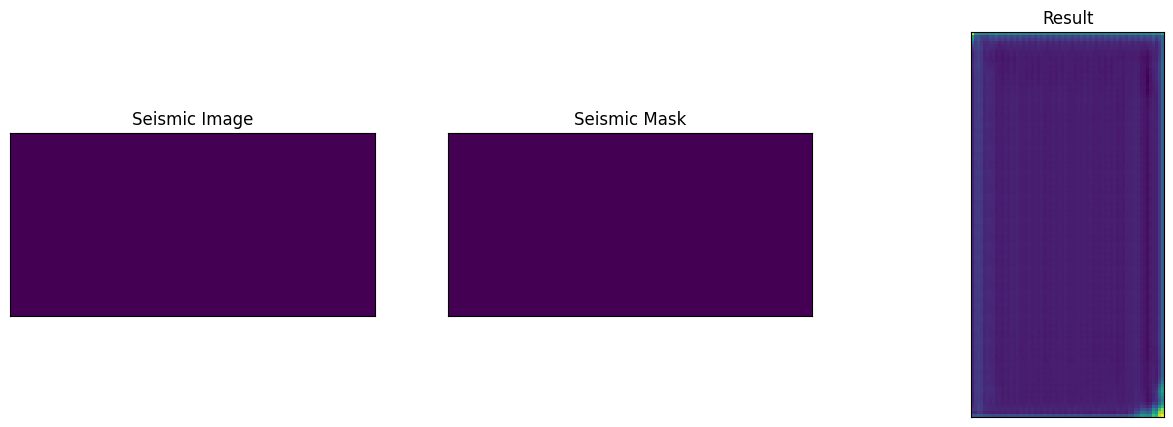

In [232]:
visualize(
    seismic_image=torch.zeros(sample[0].shape)[0][0],
    seismic_mask=torch.zeros(sample[0].shape)[0][0],
    result = (lit_model.model(torch.zeros(sample[0].shape)[None, :])[0][0][id_slice].detach().numpy().T)
)

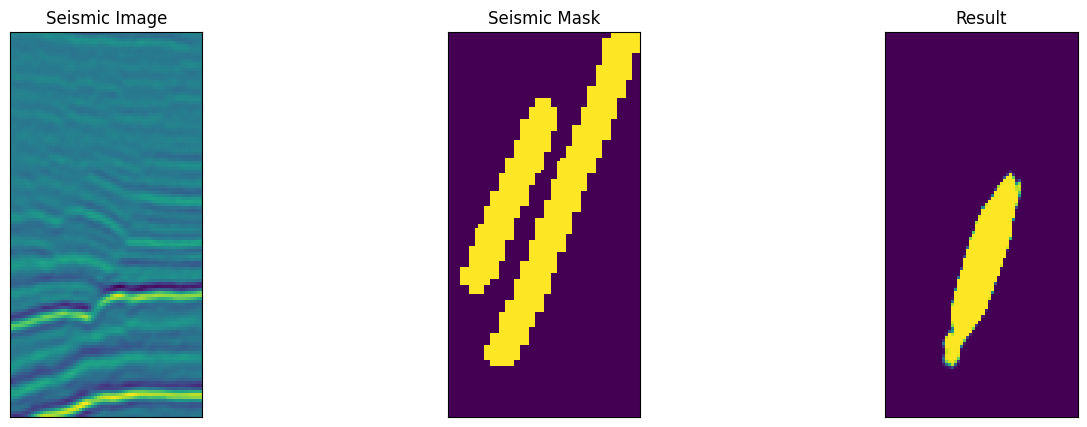

In [147]:
sample = test_dataset[1] # get some sample
id_slice = 30
image, mask = sample[0][0][id_slice].T, sample[1][0][id_slice].T
with torch.no_grad():
    lit_model.eval()
    result = lit_model.model(sample[0][None, :])
    visualize(
    seismic_image=image,
    seismic_mask=mask.squeeze(),
    result = result[0][0][id_slice].sigmoid().detach().numpy().T
    )

In [51]:
import math
from itertools import product

In [52]:
def get_windows_amount(
    length,
    step,
):
    return len(range(0, length - step, step))
def get_windows_ranges(
    length,
    window_size,
    step,
):
    for i in range(get_windows_amount(length, step)):
        print(f'index={i}, start={i*step}, end={i*step + window_size}')

In [54]:
def get_windows_ranges(
    length,
    window_size,
    step,
):
    return range(get_windows_amount(length, step))

In [56]:
def add_padding_full_data(origin_tensor: torch.Tensor):
    base_shape = (1, 1, 128, 128, 32)
    if origin_tensor.shape == base_shape:
        return origin_tensor
    cube_size = (128, 128, 32)
    required_shape = (
        1,
        1,
        math.ceil(origin_tensor.shape[0] / cube_size[2]) * cube_size[2],
        math.ceil(origin_tensor.shape[1] / cube_size[1]) * cube_size[1],
        math.ceil(origin_tensor.shape[2] / cube_size[0]) * cube_size[0],
    )
    if origin_tensor.shape == base_shape:
        return origin_tensor
    target = torch.zeros(required_shape)
    target[:, :, :origin_tensor.shape[0], :origin_tensor.shape[1], :origin_tensor.shape[2]] = origin_tensor
    return target


def add_padding(origin_tensor: torch.Tensor):
    base_shape = (1, 1, 128, 128, 32)
    if origin_tensor.shape == base_shape:
        return origin_tensor
    target = torch.zeros(base_shape)
    target[:, :, :origin_tensor.shape[2], :origin_tensor.shape[3], :origin_tensor.shape[4]] = origin_tensor
    return target

In [182]:
def prepare_seis(seis_tensr: torch.Tensor):
    X_max = seis_tensr.max()
    X_min = seis_tensr.min()
    seis_tensr = (seis_tensr - X_min) / (X_max - X_min)
    return seis_tensr

In [185]:
def get_prediction(
    seis_path: str,
    fault_path: str,
    model: torch.nn.Module,
):
    with np.load(seis_path, mmap_mode='r+') as seis_file:
        seis_tensor = torch.from_numpy(seis_file['arr_0'])
        seis_tensor = add_padding_full_data(seis_tensor)
    y_pred = torch.zeros(seis_tensor.shape)
    model.to(torch.device("cuda:0"))
    cube_size = (128, 64, 32)
    with torch.no_grad():
        for xline, iline, zline in product(
            range((seis_tensor.shape[2] // cube_size[2])),
            range((seis_tensor.shape[3] // cube_size[1])),
            range((seis_tensor.shape[4] // cube_size[0])),
        ):
            seis_slice = seis_tensor[
                :,
                :,
                (xline * cube_size[2]): (xline * cube_size[2]) + cube_size[2],
                (iline * cube_size[1]): (iline * cube_size[1]) + cube_size[1],
                (zline * cube_size[0]): (zline * cube_size[0]) + cube_size[0],
            ]
            seis_slice = prepare_seis(seis_slice)
            res = model(
                seis_slice.to(torch.device("cuda:0"))
            )
            res[seis_slice == 0] = 0
            y_pred[
                :,
                :,
                (xline * cube_size[2]): (xline * cube_size[2]) + cube_size[2],
                (iline * cube_size[1]): (iline * cube_size[1]) + cube_size[1],
                (zline * cube_size[0]): (zline * cube_size[0]) + cube_size[0],
            ] += res.cpu()
            res = None
            seis_slice = None
            torch.cuda.empty_cache()
    res = None
    seis_slice = None
    model.to(torch.device('cpu'))
    model = None
    torch.cuda.empty_cache()
    return y_pred

In [220]:
def get_prediction_slicing(
    seis_path: str,
    fault_path: str,
    model: torch.nn.Module,
):
    with np.load(seis_path, mmap_mode='r+') as seis_file:
        seis_tensor = torch.from_numpy(seis_file['arr_0'])
        seis_tensor = add_padding_full_data(seis_tensor)
    y_pred = torch.zeros(seis_tensor.shape)
    model.to(torch.device("cuda:0"))
    cube_size = (128, 64, 32)
    with torch.no_grad():
        for xline, iline, zline in product(
            get_windows_ranges(seis_tensor.shape[2], 32, 32),
            get_windows_ranges(seis_tensor.shape[3], 64, 32),
            get_windows_ranges(seis_tensor.shape[4], 128, 64),
        ):
            seis_slice = seis_tensor[
                :,
                :,
                (xline * (cube_size[2] // 2)): (xline * (cube_size[2] // 2)) + cube_size[2],
                (iline * (cube_size[1] // 2)): (iline * (cube_size[1] // 2)) + cube_size[1],
                (zline * (cube_size[0] // 2)): (zline * (cube_size[0] // 2)) + cube_size[0],
            ]
            seis_slice = prepare_seis(seis_slice)
            res = model(
                seis_slice.to(torch.device("cuda:0"))
            )
            res[seis_slice == 0] = 0
            y_pred[
                :,
                :,
                (xline * (cube_size[2] // 2)): (xline * (cube_size[2] // 2)) + cube_size[2],
                (iline * (cube_size[1] // 2)): (iline * (cube_size[1] // 2)) + cube_size[1],
                (zline * (cube_size[0] // 2)): (zline * (cube_size[0] // 2)) + cube_size[0],
            ] += res.sigmoid().cpu()
            res = None
            seis_slice = None
            torch.cuda.empty_cache()
    res = None
    seis_slice = None
    model.to(torch.device('cpu'))
    model = None
    torch.cuda.empty_cache()
    return y_pred

In [221]:
result_fault = get_prediction_slicing(seis_path, None, lit_model.model)

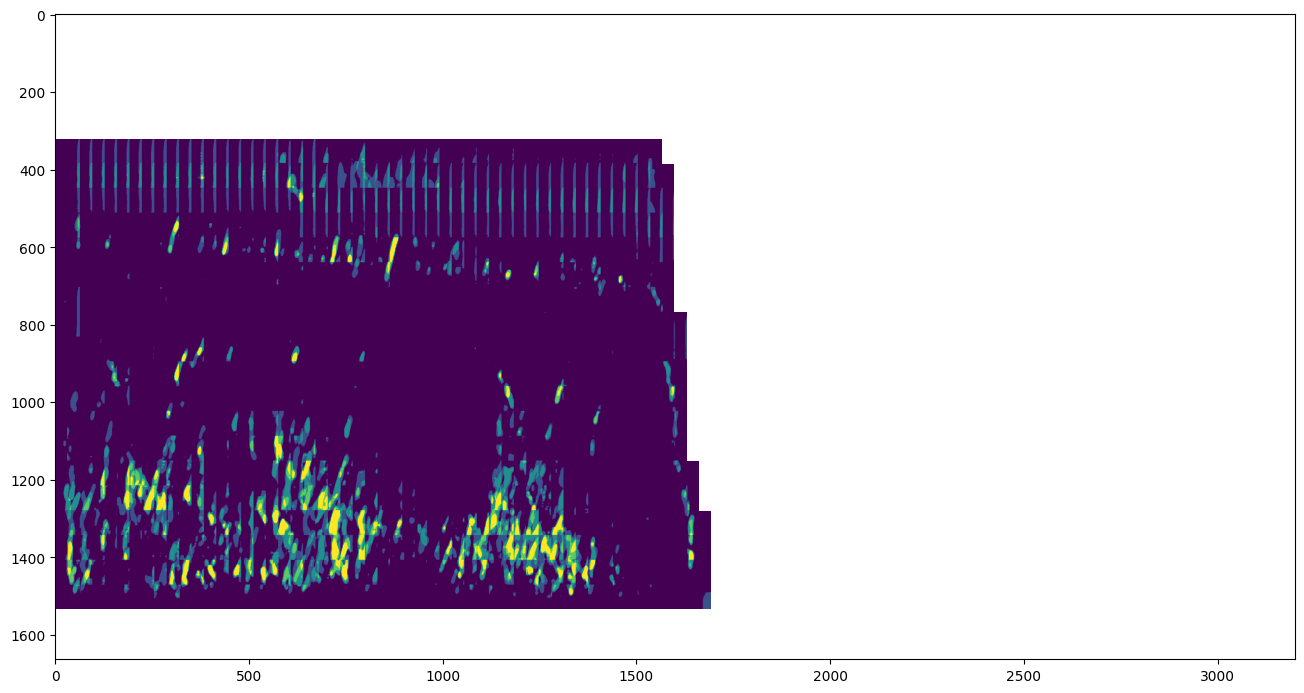

In [225]:
plt.figure(figsize=(16, 9))
plt.imshow(result_fault[0][0][0].T)

In [82]:
with np.load(fault_mask_path, mmap_mode='r+') as fault_file:
    fault_file = torch.from_numpy(fault_file['arr_0'])

In [83]:
with np.load(seis_path, mmap_mode='r+') as seis_file:
    seis_tensor = torch.from_numpy(seis_file['arr_0'])

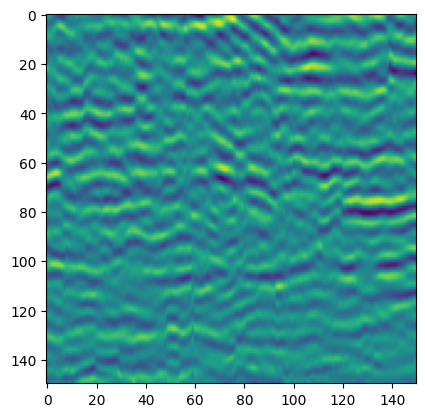

In [253]:
plt.imshow(seis_tensor[0, 1250: 1400, 1350: 1500].T)

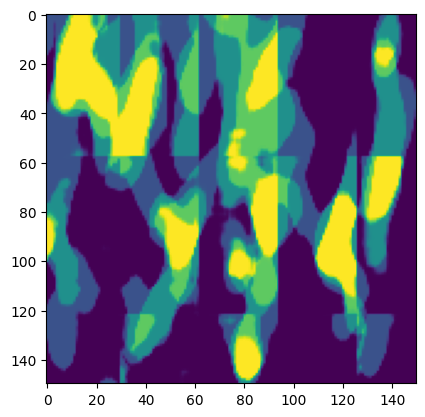

In [254]:
plt.imshow(result_fault[0,0,0, 1250: 1400, 1350: 1500].T)

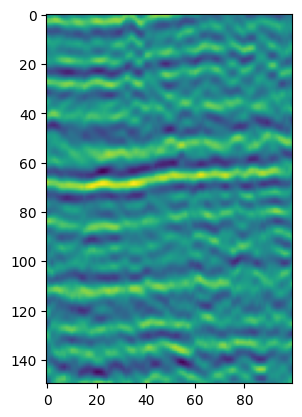

In [243]:
plt.imshow(seis_tensor[0:32, 300:400, 1250: 1400][0].T)

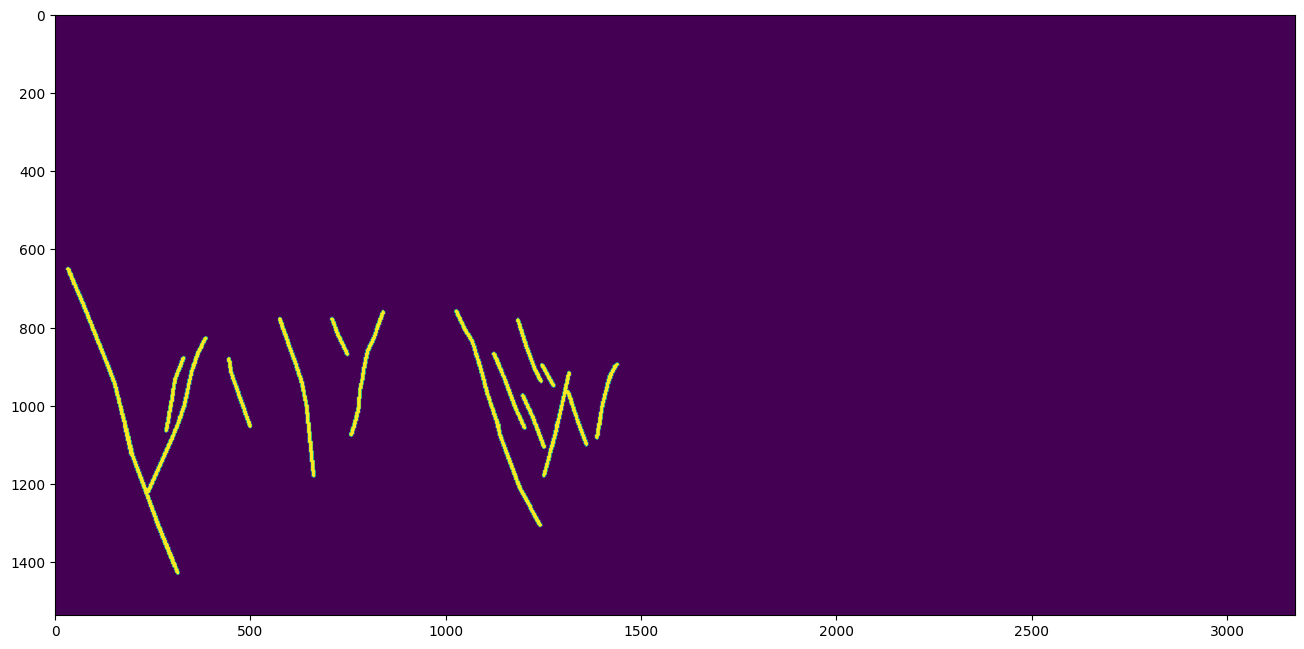

In [203]:
plt.figure(figsize=(16,9))
plt.imshow(fault_file[0].T,)

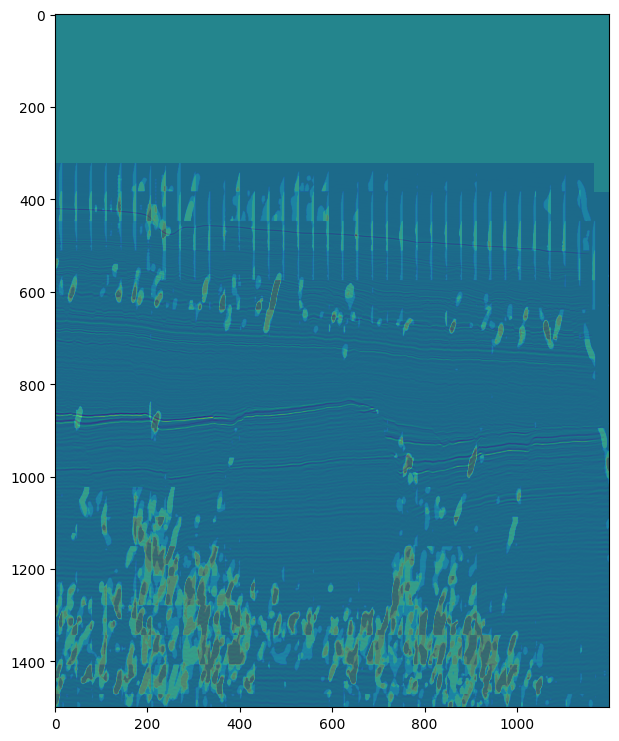

In [228]:
plt.figure(figsize=(16,9))
plt.imshow(seis_tensor[10][400:1600, :1500].T)
plt.imshow(result_fault[0][0][10][400:1600, :1500].T, cmap='jet', alpha=0.2)

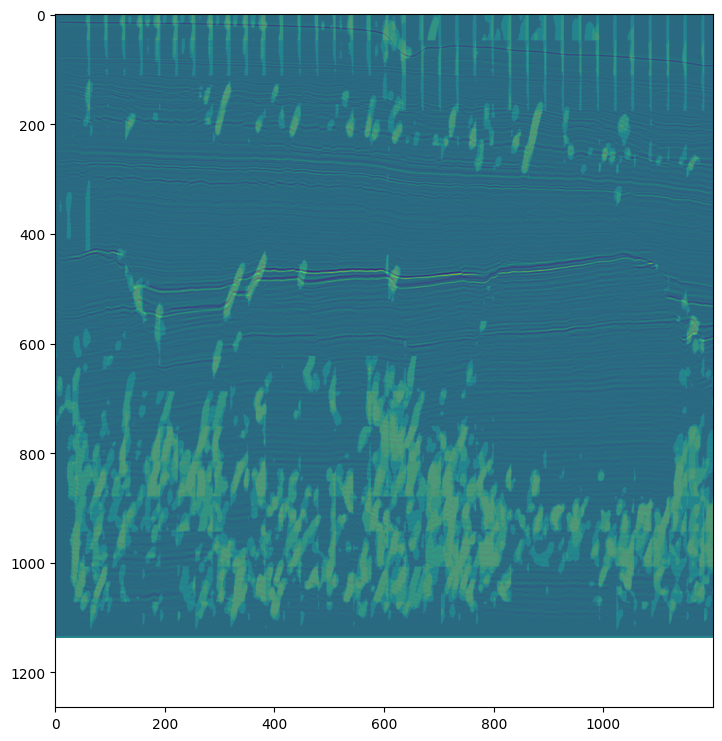

In [229]:
plt.figure(figsize=(16,9))
plt.imshow(seis_tensor[10][:1200, 400:].T, alpha=1)
plt.imshow(result_fault[0][0][10][:1200, 400:].sigmoid().T, alpha=0.2)
# plt.imshow(fault_file[80][:1200, 400:].T, cmap='jet', alpha=0.2)

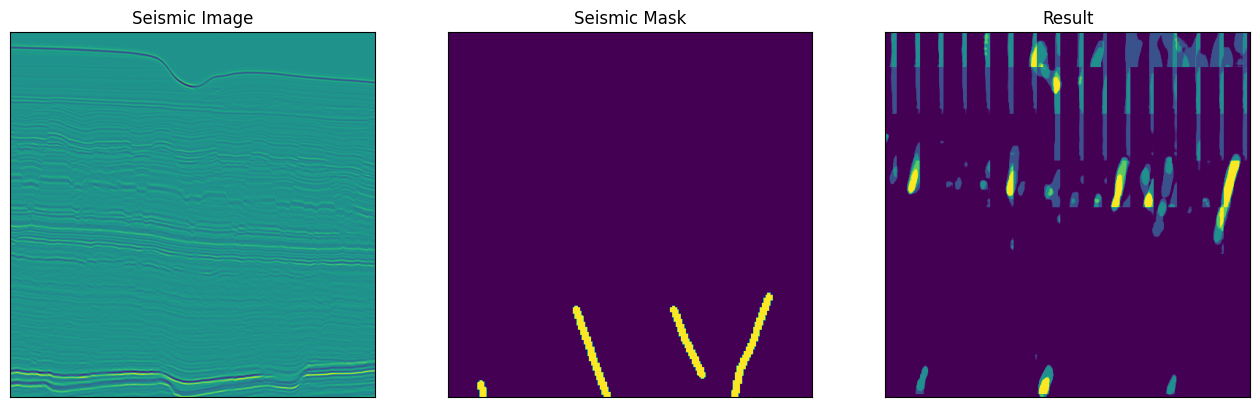

In [230]:
visualize(
    seismic_image=seis_tensor[0][400:900, 400:900].T,
    seismic_mask=fault_file[0][400:900, 400:900].T,
    result = result_fault[0][0][0][400:900, 400:900].T
)